<a href="https://colab.research.google.com/github/sugi-san/others/blob/main/DALL_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

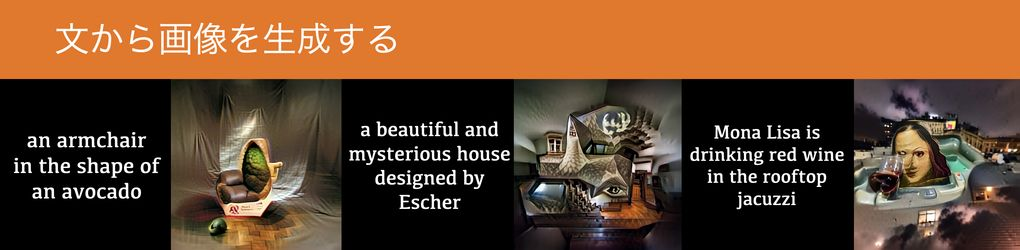

In [ ]:
#@title 1.セットアップ（数分程度かかります）
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:

      # CLIP関連コードのコピー
      ! git clone https://github.com/openai/CLIP.git
      %cd /content/CLIP/
      pbar.update(10)

      # Pytorchバージョン変更
      ! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
      ! pip install kornia 
      pbar.update(50)

      # CLIPのモデル化
      ! pip install ftfy regex
      import clip
      model, preprocess = clip.load('ViT-B/32', jit=True)  
      model = model.eval() 
      pbar.update(20)

      # DALL-Eのモデル化
      ! pip install DALL-E
      from dall_e import map_pixels, unmap_pixels, load_model
      dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')  
      pbar.update(20)

except subprocess.CalledProcessError:
  print(captured)
  raise


# 初期設定
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import kornia
import PIL
import os, io, sys
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from google.colab import output
import requests
import matplotlib.pyplot as plt
import cv2
import warnings

# 警告非表示
warnings.simplefilter('ignore')

# 初期設定
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
target_image_size = sideX
tau_value = 2.

# 画像表示・保存
def displ(img):
  img = np.array(img)[:,:,:]
  img = (np.transpose(img, (1, 2, 0))*255).astype(np.uint8) ####
  imageio.imwrite('output.png', np.array(img))
  #return display.Image('output.png')
  img = plt.imread("output.png")
  plt.axis('off')
  plt.imshow(img)
  plt.show()


# 画像のランダム切り出し
def augment(out, cutn=16):
  p_s = []
  for ch in range(cutn):
    sizey = int(torch.zeros(1,).uniform_(.5, .99)*sideY)
    sizex = int(torch.zeros(1,).uniform_(.5, .99)*sideX)
    offsetx = torch.randint(0, sideX - sizex, ())
    offsety = torch.randint(0, sideY - sizey, ())
    apper = out[:, :, offsetx:offsetx + sizex, offsety:offsety + sizey]
    apper = apper + .1*torch.rand(1,1,1,1).cuda()*torch.randn_like(apper, requires_grad=True)
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = augs(torch.cat(p_s, 0))
  return into

# 正規化と回転設定
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
augs = kornia.augmentation.RandomRotation(30).cuda()

# パラメータの設定
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        hots = torch.nn.functional.one_hot((torch.arange(0, 8192).to(torch.int64)), num_classes=8192)
        rng = torch.zeros(1, 64*64, 8192).uniform_()
        for i in range(64*64):
            rng[0,i] = hots[[np.random.randint(8191)]]
        rng = rng.permute(0, 2, 1)
        self.normu = torch.nn.Parameter(rng.cuda().view(1, 8192, 64*64))
        
    def forward(self):      
      normu = torch.nn.functional.gumbel_softmax(self.normu.reshape(1,64*64,8192), dim=1, tau=tau_value).view(1, 8192, 64, 64)
      return normu

# downloadフォルダー作成
import os
os.makedirs('download', exist_ok=True) 


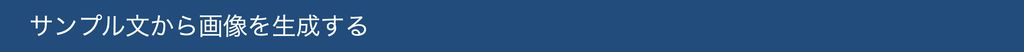

In [ ]:
#@title 2.テキストから画像の生成（数十分程度かかります）
text_input = 'an armchair in the shape of an avocado' #@param ['an armchair in the shape of an avocado', 'a beautiful and mysterious house designed by Escher', 'Mona Lisa is drinking red wine in the rooftop jacuzzi', 'Sports car designed by Gaudi'] {allow-input: true}

# テキストを特徴ベクトルに変換
token = clip.tokenize(text_input)  
text_v = model.encode_text(token.cuda()).detach().clone() 

# パラメータリセット
latent = Pars().cuda()  
param = [latent.normu]  
optimizer = torch.optim.Adam([{'params': param, 'lr': .01}]) 

# images フォルダーリセット
import os
import shutil
if os.path.isdir('images'):
   shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

# 学習ループ
for iteration in range(1001):

  # --- 順伝播 ---
  # パラメータから画像を生成
  out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3].float()))
  # 画像をランダム切り出し・回転  
  into = augment(out)
  # 画像を正規化
  into = nom((into))
  # 画像から特徴ベクトルを取得
  image_v = model.encode_image(into)
  # テキストと画像の特徴ベクトルのCOS類似度を計算 
  loss = -torch.cosine_similarity(text_v, image_v).mean()  

  # 逆伝播
  optimizer.zero_grad()
  loss.backward()
  optimizer.step() 

  # 学習率の調整
  for g in optimizer.param_groups:
    g['lr'] = g['lr']*1.005
    g['lr'] = min(g['lr'], .12)

  # ログ表示      
  if iteration % 50 == 0:
    with torch.no_grad():

      # 生成画像の表示・保存
      out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3]).float())
      displ(out.cpu()[0])  
      shutil.copy('output.png', './images/%s.png'%str(int(iteration/50)).zfill(6))

      # データ表示
      print('iter = ',iteration)
      #for g in optimizer.param_groups:
        #print('lr = ', g['lr'])
      #print('tau_value = ', tau_value)
      #print('loss = ',loss.item())
      print('\n')

In [ ]:
#@title 3.学習過程から動画を作成

# images フォルダーの最後の画像を5枚コピー
import shutil
for i in range(21,26,1):
    shutil.copy('output.png', './images/%s.png'%str(int(i)).zfill(6))

# ouput.mp4を一旦削除
import os 
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# images フォルダーの画像から動画を生成（ログ出力なし）
! ffmpeg -r 5 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p -loglevel error output.mp4

# 動画再生
from IPython.display import HTML
from base64 import b64encode
 
mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="35%" height="35%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 4.画像のダウンロード
import os
import shutil
from google.colab import files

shutil.copy('output.png', 'download/'+text_input+'.png')
files.download('download/'+text_input+'.png')


In [ ]:
#@title 5.動画のダウンロード
import os
import shutil
from google.colab import files

shutil.copy('output.mp4', 'download/'+text_input+'.mp4')
files.download('download/'+text_input+'.mp4')

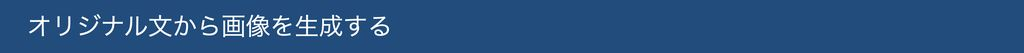

In [ ]:
#@title 6.テキストから画像の生成（数十分程度かかります）
text_input = '' #@param {type:"string"}

# テキストを特徴ベクトルに変換
token = clip.tokenize(text_input)  
text_v = model.encode_text(token.cuda()).detach().clone() 

# パラメータリセット
latent = Pars().cuda()  
param = [latent.normu]  
optimizer = torch.optim.Adam([{'params': param, 'lr': .01}]) 

# images フォルダーリセット
import os
import shutil
if os.path.isdir('images'):
   shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

# 学習ループ
for iteration in range(1001):

  # --- 順伝播 ---
  # パラメータから画像を生成
  out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3].float()))
  # 画像をランダム切り出し・回転  
  into = augment(out)
  # 画像を正規化
  into = nom((into))
  # 画像から特徴ベクトルを取得
  image_v = model.encode_image(into)
  # テキストと画像の特徴ベクトルのCOS類似度を計算 
  loss = -torch.cosine_similarity(text_v, image_v).mean()  

  # 逆伝播
  optimizer.zero_grad()
  loss.backward()
  optimizer.step() 

  # 学習率の調整
  for g in optimizer.param_groups:
    g['lr'] = g['lr']*1.005
    g['lr'] = min(g['lr'], .12)

  # ログ表示      
  if iteration % 50 == 0:
    with torch.no_grad():

      # 生成画像の表示・保存
      out = unmap_pixels(torch.sigmoid(dec(latent())[:, :3]).float())
      displ(out.cpu()[0])  
      shutil.copy('output.png', './images/%s.png'%str(int(iteration/50)).zfill(6))

      # データ表示
      print('iter = ',iteration)
      #for g in optimizer.param_groups:
        #print('lr = ', g['lr'])
      #print('tau_value = ', tau_value)
      #print('loss = ',loss.item())
      print('\n')

In [ ]:
#@title 7.学習過程から動画を作成

# images フォルダーの最後の画像を5枚コピー
import shutil
for i in range(21,26,1):
    shutil.copy('output.png', './images/%s.png'%str(int(i)).zfill(6))

# ouput.mp4を一旦削除
import os 
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# images フォルダーの画像から動画を生成（ログ出力なし）
! ffmpeg -r 5 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p -loglevel error output.mp4

# 動画再生
from IPython.display import HTML
from base64 import b64encode
 
mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="35%" height="35%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

In [ ]:
#@title 8.画像のダウンロード
import os
import shutil
from google.colab import files

shutil.copy('output.png', 'download/'+text_input+'.png')
files.download('download/'+text_input+'.png')

In [ ]:
#@title 9.動画のダウンロード
import os
import shutil
from google.colab import files

shutil.copy('output.mp4', 'download/'+text_input+'.mp4')
files.download('download/'+text_input+'.mp4')

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合は、右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックして、再度１番から順番に操作を行います。

・このノートを実行して閉じてから、すぐ再度実行する場合は、前の記憶が不完全に残っていて上手く動かないことがあります。その場合は、右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックして、再度１番から操作を行います。

・長時間使用するとgoogleから使用制限を受ける場合がありますが、12h〜24h程度経つと使用制限が解除されます。